In [1]:
!git clone https://github.com/nilrema/TraffiKING.git

Cloning into 'TraffiKING'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 195 (delta 3), reused 2 (delta 2), pack-reused 188 (from 4)
Receiving objects: 100% (195/195), 539.13 MiB | 20.17 MiB/s, done.
Resolving deltas: 100% (59/59), done.
Updating files: 100% (36/36), done.


In [2]:
import os
os.chdir('/content/TraffiKING')

## Dataset


In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Downloadanje

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)


# Download latest version
path = kagglehub.dataset_download("valentynsichkar/traffic-signs-1-million-images-for-classification")

print("Path to dataset files:", path)

100%|██████████| 612M/612M [00:05<00:00, 120MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


100%|██████████| 20.1G/20.1G [04:57<00:00, 72.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/valentynsichkar/traffic-signs-1-million-images-for-classification/versions/3


### Kopiranje u Colab folder

In [6]:
!cp -r /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1 /content/gtsrb-german-traffic-sign

In [8]:
!cp -r /root/.cache/kagglehub/datasets/valentynsichkar/traffic-signs-1-million-images-for-classification/versions/3 /content/traffic-signs-1-million-images-for-classification

## Priprema podataka

### Učitavanje podataka

In [6]:
import os
import cv2
import numpy as np

train_folder = "/content/gtsrb-german-traffic-sign/Train"
categories = 43
image_size = (64, 64)

train_images = []
train_labels = []

for label in range(categories):
    category_path = os.path.join(train_folder, str(label)) # folder path
    image_files = os.listdir(category_path)

    for image_file in image_files:
        image_path = os.path.join(category_path, image_file)
        image = cv2.imread(image_path)

        if image is not None:
            image = cv2.resize(image, image_size)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            train_images.append(image)
            train_labels.append(label)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

print("Shape of train_images:", train_images.shape)  # (num_images, 32, 32, 3)
print("Shape of train_labels:", train_labels.shape)  # (num_images,)
# broj primjera, dimenzija x dimenzija, broj kanala (RGB pa je 3)

Shape of train_images: (39209, 64, 64, 3)
Shape of train_labels: (39209,)


In [7]:
print("Train labels head: ", train_labels[:5])  # [0 0 0 0 0]

Train labels head:  [0 0 0 0 0]


### Visualizacija dijela podataka

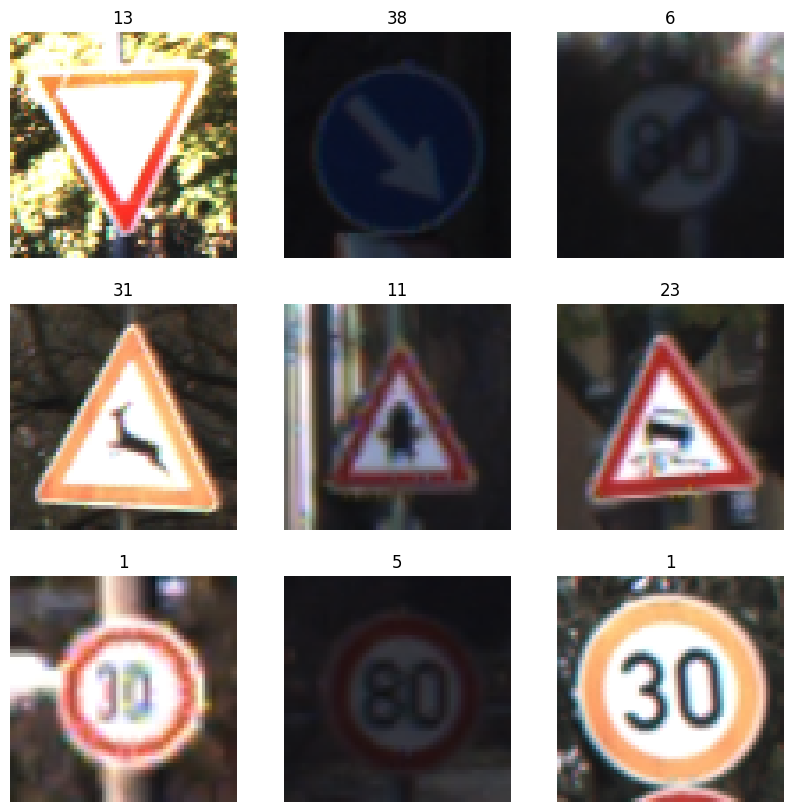

In [8]:
# visualize 9 images in 3x3 grid
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

indices = np.random.choice(len(train_images), 9)
for i, idx in enumerate(indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[idx])
    plt.title(train_labels[idx])
    plt.axis('off')

plt.show()

### Podjela na skup za treniranje i testiranje

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (31367, 64, 64, 3)
X_val shape: (7842, 64, 64, 3)
y_train shape: (31367,)
y_val shape: (7842,)


## Drugi skup podataka (domain change)

In [25]:
import h5py
import numpy as np
from PIL import Image
import os

# Path to the HDF5 file
hdf5_file_path = '/content/traffic-signs-1-million-images-for-classification/dataset_ts_original.hdf5'

# Output directory for extracted images
# output_dir = "extracted_images"
# os.makedirs(output_dir, exist_ok=True)

# Open the HDF5 file
new_domain_test_images_original = []
new_domain_test_labels = []

with h5py.File(hdf5_file_path, "r") as hdf:
    # Explore the structure
    print("Keys in the HDF5 file:", list(hdf.keys()))  # Shows the top-level groups/datasets
    new_domain_test_images_original = hdf['x_test'][:]
    new_domain_test_labels = hdf['y_test'][:]

Keys in the HDF5 file: ['x_test', 'x_train', 'x_validation', 'y_test', 'y_train', 'y_validation']


### Vizualizacija novog podatkovnog skupa

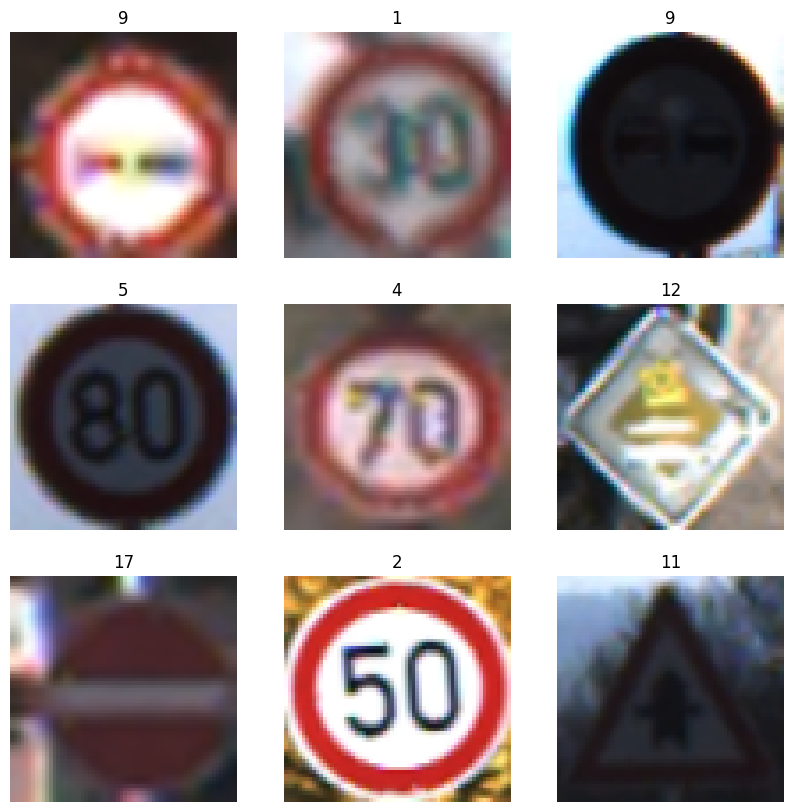

In [26]:
import cv2
import numpy as np

new_domain_test_images = []
for label, image in zip(new_domain_test_labels, new_domain_test_images_original):
  # image = cv2.imread(image)
  image = cv2.resize(image, (64, 64))
  # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = np.clip(image, 0, 255).astype(np.uint8)
  new_domain_test_images.append(image)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

indices = np.random.choice(len(new_domain_test_images), 9)
for i, idx in enumerate(indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(new_domain_test_images[idx])
    plt.title(new_domain_test_labels[idx])
    plt.axis('off')

plt.show()

## Treniranje modela

In [27]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np

class TrafficSignDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images # input, odnosno X
        self.labels = labels # output, odnosno y
        self.transform = transform # transformacija podataka

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx): # vrati odredeni X (transformirani) i y
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)), # zelimo 64x64
    transforms.ToTensor(), # pretvori u tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalizacija svih piksela
])

train_dataset = TrafficSignDataset(X_train, y_train, transform=transform)
val_dataset = TrafficSignDataset(X_val, y_val, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

NameError: name 'X_train' is not defined

In [28]:
class NewDomainTrafficSignDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images # input, odnosno X
        self.labels = labels # output, odnosno y
        self.transform = transform # transformacija podataka

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx): # vrati odredeni X (transformirani) i y
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)), # zelimo 64x64
    transforms.ToTensor(), # pretvori u tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalizacija svih piksela
])


new_domain_test_dataset = NewDomainTrafficSignDataset(new_domain_test_images, new_domain_test_labels, transform=transform)

batch_size = 64
new_domain_test_loader = DataLoader(new_domain_test_dataset, batch_size=batch_size, shuffle=False)

### Definiranje arhitekture modela

In [29]:
import torch.nn as nn
import torch

class TraffiKING(nn.Module):
    def __init__(self, num_classes=43):
        super(TraffiKING, self).__init__()

        self.layers = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, num_classes)
        )

    def forward(self, x):
        return self.layers(x)

### Training loop, postupak treniranja

In [30]:
from logger import Logger
from datetime import datetime
import sys

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, save_dir, epochs=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)  # prebacit model na cuda
    best_epoch = 0
    best_epoch_accuracy = 0

    current_time = datetime.now().strftime('%Y_%m_%d_%H_%M')
    log_dir = f'weights/{save_dir}/{current_time}'

    os.makedirs(log_dir, exist_ok=True)
    f = open(f'{log_dir}/log.txt', 'a')

    original_stdout = sys.stdout
    sys.stdout = Logger(sys.stdout, f)

    for epoch in range(epochs):
        model.train()  # model na trening mode
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device) # prebacit i podatke na cuda

            optimizer.zero_grad() # resetirat gradijente

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backprop, optimizer
            loss.backward()
            optimizer.step()

            # gubitak
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        scheduler.step()
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        # print epoha, gubitka, tocnosti
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}')

        model.eval()  # model na validation mode
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        print(f'Validation Accuracy: {val_acc:.2f}%')

        if val_acc > best_epoch_accuracy:
            best_epoch = epoch
            best_epoch_accuracy = val_acc
            torch.save(model.state_dict(), f'weights/{save_dir}/{current_time}/best_model.pt')
        print(f'BEST EPOCH: {best_epoch}, ACCURACY: {best_epoch_accuracy:.2f}%')


    torch.save(model.state_dict(), f'weights/{save_dir}/{current_time}/model.pt')
    sys.stdout = original_stdout
    f.close()

In [31]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')


## Treniranje i evaulacija modela

In [24]:
import torch.optim as optim
from torch.optim import lr_scheduler

pretrained = False
mode = 'pretrained' if pretrained else 'random_init'

### TraffiKING

In [15]:
%pip install onnx

import torch.onnx
model = TraffiKING(num_classes=43)

# Export model to ONNX format
dummy_input = torch.randn(1, 3, 64, 64)
torch.onnx.export(model, dummy_input, "model.onnx")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 85.7 MB/s eta 0:00:00


In [16]:
model = TraffiKING(num_classes=43)
criterion = nn.CrossEntropyLoss() # unakrsna entropija (strojno hehe)
optimizer = optim.Adam(model.parameters(), lr=0.001) # roko leni
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1) # smanjivanje lr-a svake 4 epohe

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, save_dir='TraffiKING')

Epoch [1/20], Loss: 1.4343, Accuracy: 66.40%, LR: 0.001000
Validation Accuracy: 83.83%
BEST EPOCH: 0, ACCURACY: 83.83%
Epoch [2/20], Loss: 0.3001, Accuracy: 92.05%, LR: 0.001000
Validation Accuracy: 91.57%
BEST EPOCH: 1, ACCURACY: 91.57%
Epoch [3/20], Loss: 0.2390, Accuracy: 94.53%, LR: 0.001000
Validation Accuracy: 93.24%
BEST EPOCH: 2, ACCURACY: 93.24%
Epoch [4/20], Loss: 0.1653, Accuracy: 96.24%, LR: 0.000100
Validation Accuracy: 93.69%
BEST EPOCH: 3, ACCURACY: 93.69%
Epoch [5/20], Loss: 0.0404, Accuracy: 98.92%, LR: 0.000100
Validation Accuracy: 96.77%
BEST EPOCH: 4, ACCURACY: 96.77%
Epoch [6/20], Loss: 0.0143, Accuracy: 99.58%, LR: 0.000100
Validation Accuracy: 96.98%
BEST EPOCH: 5, ACCURACY: 96.98%
Epoch [7/20], Loss: 0.0096, Accuracy: 99.78%, LR: 0.000100
Validation Accuracy: 97.14%
BEST EPOCH: 6, ACCURACY: 97.14%
Epoch [8/20], Loss: 0.0081, Accuracy: 99.80%, LR: 0.000010
Validation Accuracy: 97.17%
BEST EPOCH: 7, ACCURACY: 97.17%
Epoch [9/20], Loss: 0.0063, Accuracy: 99.87%, LR

### ResNet-18

In [25]:
from torchvision.models import resnet18, ResNet18_Weights

if pretrained: # ImageNet pretrained
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
else:  # Random weights
    model = resnet18(weights=None)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, save_dir=f'ResNet18/{mode}')

Epoch [1/20], Loss: 0.5183, Accuracy: 85.70%, LR: 0.001000
Validation Accuracy: 94.77%
BEST EPOCH: 0, ACCURACY: 94.77%
Epoch [2/20], Loss: 0.0825, Accuracy: 97.55%, LR: 0.001000
Validation Accuracy: 97.82%
BEST EPOCH: 1, ACCURACY: 97.82%
Epoch [3/20], Loss: 0.0496, Accuracy: 98.56%, LR: 0.001000
Validation Accuracy: 98.89%
BEST EPOCH: 2, ACCURACY: 98.89%
Epoch [4/20], Loss: 0.0380, Accuracy: 98.81%, LR: 0.000100
Validation Accuracy: 98.60%
BEST EPOCH: 2, ACCURACY: 98.89%
Epoch [5/20], Loss: 0.0074, Accuracy: 99.78%, LR: 0.000100
Validation Accuracy: 99.64%
BEST EPOCH: 4, ACCURACY: 99.64%
Epoch [6/20], Loss: 0.0018, Accuracy: 99.98%, LR: 0.000100
Validation Accuracy: 99.67%
BEST EPOCH: 5, ACCURACY: 99.67%
Epoch [7/20], Loss: 0.0009, Accuracy: 100.00%, LR: 0.000100
Validation Accuracy: 99.66%
BEST EPOCH: 5, ACCURACY: 99.67%
Epoch [8/20], Loss: 0.0006, Accuracy: 100.00%, LR: 0.000010
Validation Accuracy: 99.72%
BEST EPOCH: 7, ACCURACY: 99.72%
Epoch [9/20], Loss: 0.0005, Accuracy: 100.00%,

### EfficientNet

In [26]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

if pretrained:  # ImageNet pretrained
    model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
else:  # Random weights
    model = efficientnet_b0(weights=None)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, save_dir=f'EfficientNetB0/{mode}')

Epoch [1/20], Loss: 1.5709, Accuracy: 55.84%, LR: 0.001000
Validation Accuracy: 87.21%
BEST EPOCH: 0, ACCURACY: 87.21%
Epoch [2/20], Loss: 0.2745, Accuracy: 91.51%, LR: 0.001000
Validation Accuracy: 95.08%
BEST EPOCH: 1, ACCURACY: 95.08%
Epoch [3/20], Loss: 0.1263, Accuracy: 96.14%, LR: 0.001000
Validation Accuracy: 98.14%
BEST EPOCH: 2, ACCURACY: 98.14%
Epoch [4/20], Loss: 0.0731, Accuracy: 97.83%, LR: 0.000100
Validation Accuracy: 98.44%
BEST EPOCH: 3, ACCURACY: 98.44%
Epoch [5/20], Loss: 0.0228, Accuracy: 99.45%, LR: 0.000100
Validation Accuracy: 99.48%
BEST EPOCH: 4, ACCURACY: 99.48%
Epoch [6/20], Loss: 0.0096, Accuracy: 99.74%, LR: 0.000100
Validation Accuracy: 99.55%
BEST EPOCH: 5, ACCURACY: 99.55%
Epoch [7/20], Loss: 0.0089, Accuracy: 99.80%, LR: 0.000100
Validation Accuracy: 99.54%
BEST EPOCH: 5, ACCURACY: 99.55%
Epoch [8/20], Loss: 0.0053, Accuracy: 99.87%, LR: 0.000010
Validation Accuracy: 99.60%
BEST EPOCH: 7, ACCURACY: 99.60%
Epoch [9/20], Loss: 0.0037, Accuracy: 99.93%, LR

### MobileNetV2

In [27]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

if pretrained:  # ImageNet pretrained
    model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
else:
    model = mobilenet_v2(weights=None)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, save_dir=f'MobileNetV2/{mode}')

Epoch [1/20], Loss: 1.6952, Accuracy: 50.26%, LR: 0.001000
Validation Accuracy: 80.99%
BEST EPOCH: 0, ACCURACY: 80.99%
Epoch [2/20], Loss: 0.3322, Accuracy: 89.39%, LR: 0.001000
Validation Accuracy: 93.46%
BEST EPOCH: 1, ACCURACY: 93.46%
Epoch [3/20], Loss: 0.1539, Accuracy: 95.31%, LR: 0.001000
Validation Accuracy: 96.19%
BEST EPOCH: 2, ACCURACY: 96.19%
Epoch [4/20], Loss: 0.1083, Accuracy: 96.74%, LR: 0.000100
Validation Accuracy: 97.78%
BEST EPOCH: 3, ACCURACY: 97.78%
Epoch [5/20], Loss: 0.0288, Accuracy: 99.24%, LR: 0.000100
Validation Accuracy: 99.12%
BEST EPOCH: 4, ACCURACY: 99.12%
Epoch [6/20], Loss: 0.0125, Accuracy: 99.70%, LR: 0.000100
Validation Accuracy: 99.27%
BEST EPOCH: 5, ACCURACY: 99.27%
Epoch [7/20], Loss: 0.0084, Accuracy: 99.78%, LR: 0.000100
Validation Accuracy: 99.23%
BEST EPOCH: 5, ACCURACY: 99.27%
Epoch [8/20], Loss: 0.0052, Accuracy: 99.89%, LR: 0.000010
Validation Accuracy: 99.39%
BEST EPOCH: 7, ACCURACY: 99.39%
Epoch [9/20], Loss: 0.0043, Accuracy: 99.95%, LR

### DenseNet121

In [28]:
from torchvision.models import densenet121, DenseNet121_Weights

if pretrained:  # ImageNet pretrained
    model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
else:
    model = densenet121(weights=None)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, save_dir=f'DenseNet121/{mode}')

Epoch [1/20], Loss: 1.0930, Accuracy: 68.13%, LR: 0.001000
Validation Accuracy: 88.22%
BEST EPOCH: 0, ACCURACY: 88.22%
Epoch [2/20], Loss: 0.1145, Accuracy: 96.55%, LR: 0.001000
Validation Accuracy: 96.61%
BEST EPOCH: 1, ACCURACY: 96.61%
Epoch [3/20], Loss: 0.0606, Accuracy: 98.25%, LR: 0.001000
Validation Accuracy: 98.50%
BEST EPOCH: 2, ACCURACY: 98.50%
Epoch [4/20], Loss: 0.0407, Accuracy: 98.76%, LR: 0.000100
Validation Accuracy: 98.05%
BEST EPOCH: 2, ACCURACY: 98.50%
Epoch [5/20], Loss: 0.0081, Accuracy: 99.81%, LR: 0.000100
Validation Accuracy: 99.68%
BEST EPOCH: 4, ACCURACY: 99.68%
Epoch [6/20], Loss: 0.0028, Accuracy: 99.96%, LR: 0.000100
Validation Accuracy: 99.74%
BEST EPOCH: 5, ACCURACY: 99.74%
Epoch [7/20], Loss: 0.0015, Accuracy: 99.98%, LR: 0.000100
Validation Accuracy: 99.77%
BEST EPOCH: 6, ACCURACY: 99.77%
Epoch [8/20], Loss: 0.0013, Accuracy: 99.99%, LR: 0.000010
Validation Accuracy: 99.78%
BEST EPOCH: 7, ACCURACY: 99.78%
Epoch [9/20], Loss: 0.0007, Accuracy: 100.00%, L

# Promjena domene

### TraffiKING

In [33]:
model = TraffiKING(num_classes=43)
model.load_state_dict(torch.load('/content/TraffiKING/weights/TraffiKING/2025_01_14_10_13/best_model.pt'))
evaluate_model(model, new_domain_test_loader)

<ipython-input-33-e877059a2295>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/TraffiKING/weights/TraffiKING/2025_01_14_10_13/be

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

### ResNet18

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(weights=None)
model.load_state_dict(torch.load('/content/TraffiKING/weights/ResNet18/random_init/2025_01_14_11_22/best_model.pt'))
evaluate_model(model, new_domain_test_loader)

### EfficientNet

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

model = efficientnet_b0(weights=None)
model.load_state_dict(torch.load('/content/TraffiKING/weights/EfficientNetB0/random_init/2025_01_14_11_31/best_model.pt'))
evaluate_model(model, new_domain_test_loader)

### MobileNetV2

In [ ]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

model = mobilenet_v2(weights=None)
model.load_state_dict(torch.load('/content/TraffiKING/weights/MobileNetV2/random_init/2025_01_14_11_42/best_model.pt'))
evaluate_model(model, new_domain_test_loader)

### DenseNet121

In [ ]:
from torchvision.models import densenet121, DenseNet121_Weights

model = densenet121(weights=None)
model.load_state_dict(torch.load('/content/TraffiKING/weights/DenseNet121/random_init/2025_01_14_11_52/best_model.pt'))
evaluate_model(model, new_domain_test_loader)

In [30]:
!zip -r /content/TraffiKING/weights.zip /content/TraffiKING/weights

  adding: content/TraffiKING/weights/ (stored 0%)
  adding: content/TraffiKING/weights/MobileNetV2/ (stored 0%)
  adding: content/TraffiKING/weights/MobileNetV2/pretrained/ (stored 0%)
  adding: content/TraffiKING/weights/MobileNetV2/pretrained/2025_01_14_10_42/ (stored 0%)
  adding: content/TraffiKING/weights/MobileNetV2/pretrained/2025_01_14_10_42/log.txt (deflated 85%)
  adding: content/TraffiKING/weights/MobileNetV2/pretrained/2025_01_14_10_42/best_model.pt (deflated 8%)
  adding: content/TraffiKING/weights/MobileNetV2/pretrained/2025_01_14_10_42/model.pt (deflated 8%)
  adding: content/TraffiKING/weights/MobileNetV2/random_init/ (stored 0%)
  adding: content/TraffiKING/weights/MobileNetV2/random_init/2025_01_14_11_42/ (stored 0%)
  adding: content/TraffiKING/weights/MobileNetV2/random_init/2025_01_14_11_42/log.txt (deflated 84%)
  adding: content/TraffiKING/weights/MobileNetV2/random_init/2025_01_14_11_42/best_model.pt (deflated 9%)
  adding: content/TraffiKING/weights/MobileNetV2